In [1]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from data_cleaning import *
from keras import models
from keras import layers
%matplotlib inline

Using TensorFlow backend.


## Image Preprocessing

#### Find the minimum size of image in each folder

In [2]:
# this function exists in data-cleaning.py
test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)
print("\n")
print("The minimumn image size is: 140 x 100! We will rescale to this size")

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


The minimumn image size is: 140 x 100! We will rescale to this size


#### Image Augmentation

In [36]:
# reshape the images, flip, rotate and adjust brightness using Keras

# get all the data in the directory split/test (230 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=90, 
                                    brightness_range=[0.2,1.0], horizontal_flip=True).flow_from_directory(
    'split/test/', target_size=(140, 100),batch_size = 291)
# get all the data in the directory split/train (570 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255,rotation_range=90, 
                                     brightness_range=[0.2,1.0], horizontal_flip=True).flow_from_directory(
    'split/train/', target_size=(140, 100), batch_size=871)

# get all the data in the directory split/validation (160 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255,  rotation_range=90, 
                                   brightness_range=[0.2,1.0], horizontal_flip=True).flow_from_directory(
    'split/validation/', target_size=(140, 100), batch_size = 294)

Found 288 images belonging to 2 classes.
Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [37]:
# lets check our dataset numbers again post-reshaping 
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 867
Number of testing samples: 288
Number of validation samples: 291
train_images shape: (867, 140, 100, 3)
train_labels shape: (867, 2)
test_images shape: (288, 140, 100, 3)
test_labels shape: (288, 2)
val_images shape: (291, 140, 100, 3)
val_labels shape: (291, 2)


#### Create Data Labels 

In [38]:
# split images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [39]:
images = np.concatenate((train_images, test_images, val_images))
labels = np.concatenate((train_labels[:,0], test_labels[:,0], val_labels[:,0]))

In [45]:
train_images.shape

(867, 140, 100, 3)

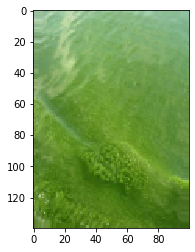

In [40]:
# show one of the images
plt.imshow(images[28])
plt.show()

#### Split train, test, and val into X & Y 

In [41]:
# split into x & y and check shape
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print("Train X:", train_img.shape)
print("Test X:", test_img.shape)
print("Val X:", val_img.shape)

train_y = np.reshape(train_labels[:,0], (867,1))
test_y = np.reshape(test_labels[:,0], (288,1))
val_y = np.reshape(val_labels[:,0], (291,1))

print("\n")
print("Train y:", train_y.shape)
print("Test y:", test_y.shape)
print("Val y:", val_y.shape)

Train X: (867, 42000)
Test X: (288, 42000)
Val X: (291, 42000)


Train y: (867, 1)
Test y: (288, 1)
Val y: (291, 1)


## Build the CNN

In [47]:
# instantiate the model 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(140, 100,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [51]:
history = model.fit(train_images,
                    train_y,
                    epochs=60,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 867 samples, validate on 291 samples
Epoch 1/60
867/867 [==============================] - 14s 16ms/step - loss: 0.4213 - acc: 0.8155 - val_loss: 0.4038 - val_acc: 0.8351
Epoch 2/60
867/867 [==============================] - 14s 16ms/step - loss: 0.4123 - acc: 0.8097 - val_loss: 0.5747 - val_acc: 0.7354
Epoch 3/60
867/867 [==============================] - 14s 16ms/step - loss: 0.4248 - acc: 0.8085 - val_loss: 0.5406 - val_acc: 0.7629
Epoch 4/60
867/867 [==============================] - 14s 16ms/step - loss: 0.4090 - acc: 0.8166 - val_loss: 0.5270 - val_acc: 0.7629
Epoch 5/60
867/867 [==============================] - 13s 15ms/step - loss: 0.3972 - acc: 0.8339 - val_loss: 0.5278 - val_acc: 0.7698
Epoch 6/60
867/867 [==============================] - 13s 15ms/step - loss: 0.4082 - acc: 0.8189 - val_loss: 0.5250 - val_acc: 0.7766
Epoch 7/60
867/867 [==============================] - 13s 15ms/step - loss: 0.3992 - acc: 0.8189 - val_loss: 0.4929 - val_acc: 0.7904
Epoch 8/60
867/8

In [52]:
results_train = model.evaluate(train_images, train_y)
results_train

867/867 [==============================] - 3s 3ms/step


[0.35249424802253265, 0.8235294222831726]

In [53]:
results_test = model.evaluate(test_images, test_y)
results_test

288/288 [==============================] - 1s 3ms/step


[0.5624870757261912, 0.7986111044883728]

In [ ]:
# Model improvements 

# manually crop images, increase saturation or contrast 
# fix scale? some images are quished, increase size 
# inception resnet
# add more layers 